In [1]:
import warnings
import re
from pathlib import Path

import docx
import geopandas as gpd
import libpysal
import numpy as np
import pandas as pd
import requests_cache
import spreg
import wbgapi as wb
from esda import Moran, Moran_Local
from scipy.sparse import csr_matrix
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder, minmax_scale


requests_cache.install_cache()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

df = pd.read_csv(
    Path.home()
    / "OneDrive"
    / "PhD Dissertation"
    / "Data_Code"
    / "Data"
    / "index_data_regvariables.csv",
    index_col=0,
)
df["SDI"] *= 100
df = df.set_index(["Year", "Alpha-3 code"]).sort_index()

SSF = sorted(list(wb.region.members("SSF")))
if (
    gadm_ssf_geojson := Path.home()
    / "OneDrive"
    / "Rawdata"
    / "Geographic Information Data"
    / "gadm_410-ssf.geo.json"
).exists():
    gdf = gpd.read_file(gadm_ssf_geojson)
else:
    gadm = gpd.read_file(
        Path.home()
        / "OneDrive"
        / "Rawdata"
        / "Geographic Information Data"
        / "gadm_410-levels.zip"
    )
    gdf = gadm.query("GID_0 in @SSF")
    gdf.to_file(gadm_ssf_geojson, driver="GeoJSON")

ROI = sorted(df.index.get_level_values(1).unique().tolist())


def distance_matrix(ROI=ROI, threshold=0):
    """Return a distance matrix of capitals in ROI. (Unit: km)

    Parameters
    ----------
    ROI : list of str
        A list of Alpha-3 codes of countries.

    Returns
    -------
    np.ndarray
        A distance matrix of capitals in ROI.
    """
    capitals = (
        gpd.read_file(
            Path.home()
            / "OneDrive"
            / "Rawdata"
            / "Geographic Information Data"
            / "首都城市地理坐标"
            / "Cities__Scale_Dependent_.shp"
        )
        .query("ADM0_A3 != 'ZAF' or NAME == 'Pretoria'")
        .query("ADM0_A3 != 'CIV' or NAME == 'Abidjan'")
        .query("ADM0_A3 in @ROI")
        .set_index("ADM0_A3")["geometry"].to_crs("EPSG:4087")
    )
    geo_distance = (
        pd.DataFrame(
            np.array(
                [
                    [
                        another.distance(capital) / 1000
                        for another in capitals
                    ]
                    for capital in capitals
                ]
            ),
            index=capitals.index,
            columns=capitals.index,
        )
    )
    return geo_distance.loc[ROI, ROI].values


def neighbor_weights(
    ROI=ROI, method="Queen", additional_neighbors=(
        ("MDG", "KEN"),
        ("MDG", "MUS"),
        ("CPV", "SEN"),
        ("SLE", "GNB")
    )
):
    """Return a neighbor matrix of capitals in ROI.

    Parameters
    ----------
    ROI : list of str
        A list of Alpha-3 codes of countries.
    method : str, {"Queen", "Rook"}
        The method of constructing neighbor matrix, by default "Queen".
    additional_neighbors : tuple, optional
        A dictionary of additional neighbors, by default None. It looks like (("MDG", "KEN"), ("MDG", "MUS"))

    Returns
    -------
    libpysal.weights.W
        A neighbor matrix of capitals in ROI.
    """
    adjlist = getattr(libpysal.weights, method).from_dataframe(
        gdf.query("GID_0 in @ROI")
    ).to_adjlist()
    if additional_neighbors is not None:
        for one, another in additional_neighbors:
            if any([one not in ROI, another not in ROI]):
                continue
            one, another = one.upper(), another.upper()
            one_idx = np.argwhere(np.array(ROI) == one).sum()
            another_idx = np.argwhere(np.array(ROI) == another).sum()
            adjlist.loc[len(adjlist)] = [one_idx, another_idx, 1.0]
            adjlist.loc[len(adjlist)] = [another_idx, one_idx, 1.0]
    return libpysal.weights.W.from_adjlist(adjlist)


def distance_weights(ROI=ROI, squared=False, threshold=0):
    """Return a neighbor matrix of capitals in ROI.

    Parameters
    ----------
    ROI : list of str
        A list of Alpha-3 codes of countries.
    squared : bool, optional
        Whether to square the distance matrix, by default False.

    Returns
    -------
    libpysal.weights.W
        A neighbor matrix of capitals in ROI.
    """
    distance = distance_matrix(ROI, threshold=threshold)
    if squared:
        distance **= 2
    weights = 1 / distance
    for i in range(len(weights)):
        weights[i, i] = 0
    weights = 1 - np.exp(-weights)
    weights *= 100
    return libpysal.weights.WSP2W(libpysal.weights.WSP(csr_matrix(weights)))


def economic_weights(economic_indicator, ROI=ROI, kind="economic", alpha=0.5):
    """Return a neighbor matrix of capitals in ROI.

    Parameters
    ----------
    economic_indicator : list of float, optional
        The economic indicator, should be same length as ROI, by default None.
    ROI : list of str
        A list of Alpha-3 codes of countries.
    kind : str, optional
        The method of constructing neighbor matrix, by default "economic".
    alpha : float, optional
        The weight of geographic distance, by default 0.5.

    Returns
    -------
    libpysal.weights.W
        A neighbor matrix of capitals in ROI.
    """
    economic_matrix = np.tile(economic_indicator, (len(ROI), 1))
    d = 1 / distance_matrix(ROI)
    d[d == np.inf] = 0
    d_2 = d ** 2
    # d = minmax_scale(d)
    # d_2 = minmax_scale(d_2)

    if kind == "economic_gravity":
        weights = economic_matrix * economic_matrix.T * d_2
    elif kind.startswith("economic"):
        weights = 1 / np.abs(economic_matrix - economic_matrix.T)

        if kind == "economic_multiply_distance":
            weights *= d
        elif kind == "economic_plus_distance":
            weights *= 1 - alpha
            weights += alpha * d
    else:
        raise ValueError(
            "kind should be one of economic_gravity, economic_distance, economic_multiple_distance, economic_plus_distance"
        )
    for i in range(len(weights)):
        weights[i, i] = 0
    # weights = minmax_scale(weights)
    return libpysal.weights.WSP2W(libpysal.weights.WSP(csr_matrix(weights)))


def region_weights(ROI=ROI):
    """Return a neighbor matrix of capitals in ROI.

    Returns
    -------
    libpysal.weights.W
        A neighbor matrix of capitals in ROI.
    """

    region = (
        pd.read_excel(
            Path.home()
            / "OneDrive"
            / "Rawdata"
            / "Country Classification"
            / "UN Classification_Natural resources_Geography.xlsx"
        )
        .query("`Alpha-3 code` in @ROI").sort_values("Alpha-3 code")["Region"]
        .values
    )
    weights = np.array(
        [[1 if one == another else 0 for another in region] for one in region]
    )
    for i in range(len(weights)):
        weights[i, i] = 0
    return libpysal.weights.WSP2W(libpysal.weights.WSP(csr_matrix(weights)))


def get_weights(kind, economic_indicator=None, ROI=ROI, alpha=0.5, threshold=0):
    """Return a weights matrix of capitals in ROI.

    Parameters
    ----------
    kind : str
        The kind of weights.
    economic_indicator : np.ndarray, optional
        A 1-d array of economic indicator, by default None.
    ROI : list of str, optional
        A list of Alpha-3 codes of countries, by default ROI.
    alpha : float, optional
        A float between 0 and 1, by default 0.5.

    Returns
    -------
    libpysal.weights.W
        A weights matrix of capitals in ROI.
    """
    match kind:
        case "distance":
            return distance_weights(ROI, threshold=threshold)
        case "distance_squared":
            return distance_weights(ROI, squared=True)
        case "economic" | "economic_gravity" | "economic_multiply_distance" | "economic_plus_distance":
            return economic_weights(economic_indicator, ROI, kind=kind, alpha=alpha)
        case "neighbor":
            return neighbor_weights(ROI)
        case "region":
            return region_weights(ROI)
        case _:
            raise ValueError("Invalid kind of weights.")


/opt/homebrew/Caskroom/mambaforge/base/envs/new-africa/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/homebrew/Caskroom/mambaforge/base/envs/new-africa/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/homebrew/Caskroom/mambaf

In [2]:
len(ROI)

35

In [3]:
from docx.shared import Pt
from docx.oxml.ns import qn
def to_docx(data: pd.DataFrame, path, index=True):
    doc = docx.Document()
    style = doc.styles['Normal']
    font = style.font
    font.name = 'Times New Roman'
    font.size = Pt(6.5)
    rPr = style.element.get_or_add_rPr()
    rPr.rFonts.set(qn('w:eastAsia'), '宋体')
    index_cols = data.index.nlevels if index else 0
    column_rows = data.columns.nlevels
    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(data.shape[0] + column_rows, data.shape[1] + index_cols)

    # add the header rows.
    for j in range(data.shape[-1]):
        cell = t.cell(0, j + index_cols)
        for k in range(column_rows):
            cell = t.cell(k, j + index_cols)
            if column_rows > 1 and j > 0 and data.columns[j - 1][k] == data.columns[j][k]:
                t.cell(k, j + index_cols - 1).merge(t.cell(k, j + index_cols))
                continue
            if column_rows == 1:
                content = data.columns[j]
            else:
                content = data.columns[j][k]
            cell.text = content

    # add the rest of the data frame
    for i in range(data.shape[0]):
        if index:
            for k in range(index_cols):
                cell = t.cell(i + column_rows, k)
                if index_cols > 1 and i > 0 and data.index[i - 1][k] == data.index[i][k]:
                    t.cell(i + column_rows - 1, k).merge(cell)
                    continue
                if data.index[i][k].startswith("I(") and data.index[i][k].endswith(")"):
                    if index_cols == 1:
                        content = data.index[i][2:-1]
                    else:
                        content = data.index[i][k][2:-1]
                else:
                    if index_cols == 1:
                        content = data.index[i]
                    else:
                        content = data.index[i][k]
                if "^" in content:
                    normal, superscript = content.split("^", 1)
                    paragraph = cell.paragraphs[0]
                    paragraph.add_run(normal)
                    run = paragraph.add_run(superscript)
                    run.font.superscript = True
                else:
                    cell.text = content
        for j in range(data.shape[-1]):
            if not pd.isna(data.values[i, j]):
                t.cell(i + column_rows, j + index_cols).text = str(data.values[i, j])

    # save the doc
    doc.save(path)

In [4]:
def splm(
    formula,
    data,
    model="error",
    weights="neighbor",
    economic_indicator="GNI per capita (US$)",
    alpha=0.5,
    name_ds="Sustainable Development Index",
    threshold=0,
    **kwargs,
):
    """Spatial panel linear model.
    
    Parameters
    ----------
    formula : str
        The formula of model.
    data : pd.DataFrame
        The data of model. It should be two-level index, the first level is time, the second level is Alpha-3 code.
    model : str, optional
        The model of model, by default "error".
    weights : str, optional
        The weights of model, by default "neighbor".
    economic_indicator : str, optional
        The economic indicator, by default "GDP per capita (current US$)_x".
    alpha : float, optional
        The weight of geographic distance, by default 0.5.
    name_ds : str, optional
        The name of dataset, by default "Sustainable Development Index".
    **kwargs : dict
        Other parameters of model.
    
    Returns
    -------
    spreg.Panel_FE_Error | spreg.Panel_FE_Lag
        The model.
    """
    data = data.copy().sort_index()
    ROI = sorted(data.index.get_level_values(1).unique().tolist())
    match weights:
        case str():
            w = get_weights(
                weights, data.groupby(level=1)[economic_indicator].mean(), ROI, alpha, threshold
            )
        case libpysal.weights.W():
            w = weights
        case _:
            raise ValueError("Invalid weights.")
    name_y, name_x = formula.split("~")
    name_y = name_y.strip()
    name_y = [name_y]
    name_x = [name.strip() for name in name_x.split("+")]

    y = data[name_y].values
    for name in name_x:
        if name in data.columns:
            continue
        data[name] = 0
        if (m := re.match(r"lag\s*\(\s*(\w+)\s*\)", name)) is not None:
            lag_x = [
                libpysal.weights.spatial_lag.lag_spatial(
                    w, data.loc[time, m.group(1)].values
                )
                for time in sorted(data.index.get_level_values(0).unique())
            ]
            data[name] = np.concatenate(lag_x)
        if (m := re.match(r"I\s*\(\s*(\w+)\s*\^\s*(\d+)\s*\)", name)) is not None:
            var = m.group(1)
            data[name] = data[var] ** int(m.group(2))
        elif (
            m := re.match(r"I\s*\(\s*lag\s*\(\s*(\w+)\s*\)\s*\^\s*(\d+)\s*\)", name)
        ) is not None:
            lag_x = [
                libpysal.weights.spatial_lag.lag_spatial(
                    w, data.loc[time, m.group(1)].values
                )
                for time in sorted(data.index.get_level_values(0).unique())
            ]
            data[name] = np.concatenate(lag_x) ** int(m.group(2))
    x = data[name_x].values

    if model == "error":
        reg = spreg.Panel_FE_Error
    elif model == "lag":
        reg = spreg.Panel_FE_Lag
    else:
        raise ValueError("model must be one of 'error' or 'lag'.")
    return reg(
        y,
        x,
        w,
        name_y=name_y,
        name_x=name_x,
        name_ds=name_ds,
        name_w=str(weights),
        **kwargs,
    )


In [5]:
selected_weights = {
    "地理邻接矩阵": "neighbor",
    "地理距离矩阵": "distance",
    "地理距离的平方": "distance_squared",
    "经济距离矩阵": "economic",
    "经济重力矩阵": "economic_gravity",
    "经济地理矩阵": "economic_multiply_distance",
    "经济指标与地理距离的加权和": "economic_plus_distance",
    "地理区域": "region",
}


def eval_tests(y, x, w):
    """Evaluate the tests of spatial dependence.

    Parameters
    ----------
    y : np.ndarray
        The dependent variable.
    x : np.ndarray
        The independent variable.
    w : libpysal.weights.W
        The weights matrix.

    Returns
    -------
    list of str
        The results of tests. Should follow the order of LM-Lag, Robust LM-Lag, LM-Error, Robust LM-Error.
    """

    def format_test_result(result):
        if isinstance(result, tuple):
            p_value = result[1]
            statistic = result[0]
        else:
            p_value = result["p-value"]
            statistic = result["likr"]
        if p_value < 0.01:
            stars = "***"
        elif p_value < 0.05:
            stars = "**"
        elif p_value < 0.1:
            stars = "*"
        else:
            stars = ""
        return f"{statistic:.2f}{stars}"
    print("y.shape", y.shape)
    print("x.shape", x.shape)
    print("w.n", w.n)
    return [
        format_test_result(spreg.panel_LMlag(y, x, w)),
        format_test_result(spreg.panel_rLMlag(y, x, w)),
        format_test_result(spreg.panel_LMerror(y, x, w)),
        format_test_result(spreg.panel_rLMerror(y, x, w)),
    ]


def get_test_results(
    formula, data, weights, economic_indicator="GNI per capita (constant 2015 US$)_x", alpha=0.5
):
    """Get the results of tests of spatial dependence.

    Parameters
    ----------
    formula : str
        The formula of model.
    data : pd.DataFrame
        The data of model. It should be two-level index, the first level is time, the second level is Alpha-3 code.
    weights : dict
        The weights of model.
    economic_indicator : str, optional
        The economic indicator, by default "GDP per capita (current US$)_x".
    alpha : float, optional
        The weight of geographic distance, by default 0.5.

    Returns
    -------
    pd.DataFrame
        The results of tests.
    """
    data = (
        data.reset_index()
        .sort_values(["Alpha-3 code", "Year"])
        .set_index(["Alpha-3 code", "Year"])
    )
    ROI = sorted(data.index.get_level_values(0).unique().tolist())
    print(len(ROI))
    w = get_weights(
                    "neighbor", data.groupby(level=0)[economic_indicator].mean(), ROI, alpha
                )
    print(w.n)
    return pd.DataFrame(
        {
            k: eval_tests(
                data[[formula.split("~")[0].strip()]].values,
                data[
                    [col.strip() for col in formula.split("~")[1].strip().split("+")]
                ].values,
                get_weights(
                    v, data.groupby(level=0)[economic_indicator].mean(), ROI, alpha
                ),
            )
            for k, v in weights.items()
        },
        index=["LM-Lag", "Robust LM-Lag", "LM-Error", "Robust LM-Error"],
    )


formula = "SDI ~ lnFDIstock + economic + WGI + natural + urban + military"


def get_LR_test(data):
    def format_test_result(result):
        if isinstance(result, tuple):
            p_value = result[1]
            statistic = result[0]
        else:
            p_value = result["p-value"]
            statistic = result["likr"]
        if p_value < 0.01:
            stars = "***"
        elif p_value < 0.05:
            stars = "**"
        elif p_value < 0.1:
            stars = "*"
        else:
            stars = ""
        return f"{statistic:.2f}{stars}"

    res = {}
    for k, v in selected_weights.items():
        lag_reg = splm(formula, data, weights=v, model="lag")
        error_reg = splm(formula, data, weights=v, model="error")
        try:
            sdm = splm(
                "SDI ~ lnFDIstock + lag(lnFDIstock) + economic + WGI + natural + urban + military",
                data,
                weights=v,
                model="lag",
            )
            res[k] = [
                format_test_result(spreg.likratiotest(lag_reg, sdm)),
                format_test_result(spreg.likratiotest(error_reg, sdm)),
            ]
        except Exception as e:
            print(e)
            continue
    return pd.DataFrame(
        res,
        index=[
            "LR(SAR)",
            "LR(SEM)",
        ],
    )


# pd.concat([
#     get_test_results(formula, df, selected_weights),
#     get_LR_test(df),
# ])
get_test_results(formula, df, selected_weights)

35
35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35
y.shape (700, 1)
x.shape (700, 6)
w.n 35


,地理邻接矩阵,地理距离矩阵,地理距离的平方,经济距离矩阵,经济重力矩阵,经济地理矩阵,经济指标与地理距离的加权和,地理区域
LM-Lag,1.33,4.92**,3.98**,1.11,0.00,1.28,1.51,3.62*
Robust LM-Lag,0.67,2.41,2.53,0.34,2.46,0.43,0.47,0.29
LM-Error,250.61***,73.62***,11.36***,17.63***,12.06***,19.15***,22.72***,595.94***
Robust LM-Error,249.70***,69.33***,9.96***,16.86***,10.62***,18.31***,21.69***,591.24***


<Axes: >

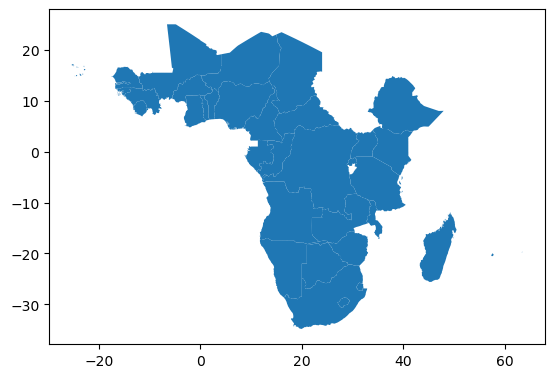

In [6]:
gdf.query("GID_0 in @ROI").plot()

In [7]:
df

Numeric       FDIstock  \
Year Alpha-3 code                           
2001 AGO                24   10122.633000   
     BEN               204     173.823669   
     BFA               854      15.910123   
     BWA                72    1388.495884   
     CAF               140     109.489683   
...                    ...            ...   
2020 TZA               834   16558.843620   
     UGA               800   14527.919560   
     ZAF               710  136735.197500   
     ZMB               894   19368.293380   
     ZWE               716    5906.977283   

                   GNI per capita (constant 2015 US$)_x  economic       WGI  \
Year Alpha-3 code                                                             
2001 AGO                                    2104.785660  2.270250 -1.293468   
     BEN                                     904.890269  4.395267 -0.236239   
     BFA                                     442.978740  2.818406 -0.292623   
     BWA                                    4738.522448  5.438610  0.781525   
     CAF                                     576.929863  2.471472 -1.223733   
...                                                 ...       ...       ...   
2020 TZA                                    1008.100830  4.974840 -0.588707   
     UGA                                     901.872841  4.062173 -0.657546   
     ZAF                                    5856.752767  6.302383  0.066755   
     ZMB                                            NaN  3.438081 -0.564687   
     ZWE                                    1179.933373  4.349229 -1.249868   

                     natural     urban  military incomegroup  IMFgroup_3  ...  \
Year Alpha-3 code                                                         ...   
2001 AGO           44.219477  5.627442  4.524354           L         1.0  ...   
     BEN            3.084829  3.836005  0.357971           L         0.0  ...   
     BFA            4.767833  6.867020  1.299790           L         2.0  ...   
     BWA            1.163854  3.574933  3.831223          UM         2.0  ...   
     CAF           10.870925  2.466582  1.356907           L         2.0  ...   
...                      ...       ...       ...         ...         ...  ...   
2020 TZA            3.851695  5.099205  1.026224          LM         2.0  ...   
     UGA            7.563490  5.737879  2.597145           L         0.0  ...   
     ZAF            4.017775  1.965305  1.101532          UM         2.0  ...   
     ZMB           16.222231  4.189738  1.154225          LM         2.0  ...   
     ZWE            4.746668  2.130421  0.005400          LM         2.0  ...   

                   incomegroup2013 incomegroup2014  incomegroup2015  \
Year Alpha-3 code                                                     
2001 AGO                         1               1                1   
     BEN                         0               0                0   
     BFA                         0               0                0   
     BWA                         1               1                1   
     CAF                         0               0                0   
...                            ...             ...              ...   
2020 TZA                         0               0                0   
     UGA                         0               0                0   
     ZAF                         1               1                1   
     ZMB                         1               1                1   
     ZWE                         0               0                0   

                   incomegroup2016  incomegroup2017  incomegroup2018  \
Year Alpha-3 code                                                      
2001 AGO                         1                1                1   
     BEN                         0                0                0   
     BFA                         0                0                0   
     BWA                         1                1                

In [8]:
from itertools import product
regs = {
    (name, f"({i + 1})"): splm(
        formula, df, weights=weights, model="error",
    )
    for i, ((name, weights), formula) in enumerate(product(selected_weights.items(), (
        # "SDI ~ lnFDIstock + lngnic + WGI  + natural + financial + urban",
        # "SDI ~ lnFDIstock + lag(lnFDIstock) + lngnic + WGI + natural + financial + urban",
        "SDI ~ lnFDIstock + I(lnFDIstock^2)+ lngnic + WGI  + natural + urban + war_intensity",
        # "SDI ~ lnFDIstock + I(lnFDIstock^2) + lag(lnFDIstock) + I(lag(lnFDIstock)^2) + lngnic + WGI + natural + financial + urban",
    )))
}
def distance_weights(ROI=ROI, squared=False, threshold=0):
    """Return a neighbor matrix of capitals in ROI.

    Parameters
    ----------
    ROI : list of str
        A list of Alpha-3 codes of countries.
    squared : bool, optional
        Whether to square the distance matrix, by default False.

    Returns
    -------
    libpysal.weights.W
        A neighbor matrix of capitals in ROI.
    """
    distance = distance_matrix(ROI, threshold=threshold)
    if squared:
        distance **= 2
    weights = 1 / distance
    for i in range(len(weights)):
        weights[i, i] = 0
    weights = 1 - np.exp(-weights)
    weights *= 10000
    return libpysal.weights.WSP2W(libpysal.weights.WSP(csr_matrix(weights)))

def get_weights(kind, economic_indicator=None, ROI=ROI, alpha=0.5, threshold=0):
    """Return a weights matrix of capitals in ROI.

    Parameters
    ----------
    kind : str
        The kind of weights.
    economic_indicator : np.ndarray, optional
        A 1-d array of economic indicator, by default None.
    ROI : list of str, optional
        A list of Alpha-3 codes of countries, by default ROI.
    alpha : float, optional
        A float between 0 and 1, by default 0.5.

    Returns
    -------
    libpysal.weights.W
        A weights matrix of capitals in ROI.
    """
    match kind:
        case "distance":
            return distance_weights(ROI, threshold=threshold)
        case "distance_squared":
            return distance_weights(ROI, squared=True)
        case "economic" | "economic_gravity" | "economic_multiply_distance" | "economic_plus_distance":
            return economic_weights(economic_indicator, ROI, kind=kind, alpha=alpha)
        case "neighbor":
            return neighbor_weights(ROI)
        case "region":
            return region_weights(ROI)
        case _:
            raise ValueError("Invalid kind of weights.")

def reg2series(reg):
    def stars(result):
        if result[1] < 0.01:
            stars = "***"
        elif result[1] < 0.05:
            stars = "**"
        elif result[1] < 0.1:
            stars = "*"
        else:
            stars = ""
        return stars

    if any("^2" in name for name in reg.name_x):
        a, b = reg.betas[0, 0], reg.betas[1, 0]
        inflection = f"{-a / (2 * b):.2f}"
        upper = f"{df['lnFDIstock'].max():.2f}"
        lower = f"{df['lnFDIstock'].min():.2f}"
    else:
        inflection = upper = lower = ""
    if isinstance(reg, spreg.Panel_FE_Error):
        lam = f"{reg.lam:.2f}{stars(reg.z_stat[-1])}"
    else:
        lam = ""
    if isinstance(reg, spreg.Panel_FE_Lag):
        rho = f"{reg.rho:.2f}{stars(reg.z_stat[-1])}"
    else:
        rho = ""
    return pd.Series(
        [
            f"{beta:.2f}{stars(z_stat)}\n({z_stat[0]:.2f})"
            for beta, z_stat in zip(reg.betas[:, 0], reg.z_stat)
        ]
        + [
            rho,
            lam,
            f"{reg.sig2[0, 0]:.2f}",
            f"{reg.n:.0f}",
            f"{reg.pr2:.2f}",
            f"{reg.logll:.2f}",
            f"{reg.aic:.2f}",
            f"{reg.schwarz:.2f}",
            inflection,
            upper,
            lower,
        ],
        index=reg.name_x
        + ["rho", "\u03bb", "\u03c3^2", "N", "R^2", "LogL", "AIC", "Schwarz criterion", "拐点", "上限", "下限"],
    )


summaries = pd.DataFrame({k: reg2series(v) for k, v in regs.items()}).loc[
    [
        # "lnFDIstock",
        "I(lnFDIstock^2)",
        "\u03bb",
        # "lag(lnFDIstock)",
        # "I(lag(lnFDIstock)^2)",
        "lngnic",
        "WGI",
        "natural",
        "urban",
        "war_intensity",
        # "rho",
        "\u03c3^2",
        "N",
        "R^2",
        "LogL",
        "AIC",
        "Schwarz criterion",
        "拐点",
        "上限",
        "下限",
    ]
]
summaries

KeyError: 'Column not found: GNI per capita (US$)'

In [ ]:
res = df.copy()
res["lnFDIstock"] = winsorize(res["lnFDIstock"], limits=(0.01, 0.01))
res["lngnic"] = winsorize(res["lngnic"], limits=(0.01, 0.01))
res["WGI"] = winsorize(res["WGI"], limits=(0.01, 0.01))
res["natural"] = winsorize(res["natural"], limits=(0.01, 0.01))
res["urban"] = winsorize(res["urban"], limits=(0.01, 0.01))
res["war_intensity"] = winsorize(res["war_intensity"], limits=(0.01, 0.01))


winsor_regs = {
    (name, f"({i + 1})"): splm(
        formula, res, weights=weights, model="error",# economic_indicator="GNI per capita (US$)"
    )
    for i, ((name, weights), formula) in enumerate(product(selected_weights.items(), (
        "SDI ~ lnFDIstock + lngnic + WGI  + natural + urban + war_intensity",
        "SDI ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + natural + urban + war_intensity",
    )))
}



winsor_summaries = pd.DataFrame({k: reg2series(v) for k, v in winsor_regs.items()}).loc[
    [
        "lnFDIstock",
        "I(lnFDIstock^2)",
        "lngnic",
        "WGI",
        "natural",
        "war_intensity",
        "urban",
        "\u03bb",
        "\u03c3^2",
        "N",
        "R^2",
        "LogL",
        "AIC",
        "Schwarz criterion",
        "拐点",
        "上限",
        "下限",
    ]
]
winsor_summaries

地理邻接矩阵                                地理距离矩阵  \
                                 (1)                (2)                (3)   
lnFDIstock           1.04***\n(7.88)       0.64\n(1.01)    1.12***\n(8.92)   
I(lnFDIstock^2)                  NaN       0.02\n(0.58)                NaN   
lngnic               1.02***\n(2.91)    1.41***\n(3.94)    1.57***\n(4.69)   
WGI                    0.72*\n(1.72)       0.61\n(1.29)       0.35\n(0.68)   
natural            -0.07***\n(-3.68)   -0.04**\n(-2.20)  -0.06***\n(-3.66)   
war_intensity         -0.05\n(-0.38)     -0.08\n(-0.64)     -0.05\n(-0.39)   
urban              -0.99***\n(-5.50)  -1.18***\n(-6.16)  -1.10***\n(-5.50)   
λ                            0.46***            0.08***              0.00*   
σ^2                             2.29               1.47               1.60   
N                                416                416                416   
R^2                             0.50               0.50               0.50   
LogL                        -2037.07           -1931.01           -1942.68   
AIC                          4086.13            3876.01            3897.36   
Schwarz criterion            4110.31            3904.23            3921.55   
拐点                                               -13.14                      
上限                                                12.10                      
下限                                                 4.34                      

                                                地理距离的平方                     \
                                 (4)                (5)                (6)   
lnFDIstock            -0.16\n(-0.26)    1.12***\n(8.89)     -0.40\n(-0.60)   
I(lnFDIstock^2)        0.07*\n(1.80)                NaN     0.10**\n(2.36)   
lngnic               1.79***\n(6.42)    1.57***\n(4.64)    1.38***\n(4.00)   
WGI                     0.13\n(0.26)       0.34\n(0.66)       0.55\n(1.07)   
natural               -0.01\n(-1.01)  -0.06***\n(-3.69)  -0.05***\n(-2.93)   
war_intensity           0.04\n(0.43)     -0.07\n(-0.51)     -0.09\n(-0.70)   
urban              -0.63***\n(-3.91)  -1.14***\n(-5.60)  -1.07***\n(-5.35)   
λ                            0.00***               0.00               0.00   
σ^2                             1.71               1.61               1.59   
N                                416                416                416   
R^2                             0.49               0.50               0.51   
LogL                        -1938.51           -1943.98           -1941.38   
AIC                          3891.02            3899.96            3896.77   
Schwarz criterion            3919.24            3924.15            3924.98   
拐点                              1.12                                  1.93   
上限                             12.10                                 12.10   
下限                              4.34                                  4.34   

                              经济距离矩阵                                经济重力矩阵  \
                                 (7)                (8)                (9)   
lnFDIstock           1.10***\n(8.72)     -0.31\n(-0.46)    1.13***\n(8.97)   
I(lnFDIstock^2)                  NaN     0.09**\n(2.16)                NaN   
lngnic               1.57***\n(4.61)    1.38***\n(3.97)    1.57***\n(4.65)   
WGI                     0.36\n(0.70)       0.57\n(1.10)       0.34\n(0.67)   
natural            -0.06***\n(-3.62)  -0.05***\n(-2.80)  -0.06***\n(-3.72)   
war_intensity         -0.09\n(-0.64)     -0.12\n(-0.92)     -0.06\n(-0.45)   
urban              -1.15***\n(-5.61)  -1.09***\n(-5.33)  -1.12***\n(-5.55)   
λ                               0.08               0.15               0.00   
σ^2                             1.61               1.59               1.61   
N                                416                416                416   
R^2                             0.50               0.51               0.50   
LogL                        -1944.12           -19

In [ ]:
res = df.copy().query("Year < 2020")


no_covid_regs = {
    (name, f"({i + 1})"): splm(
        formula, res, weights=weights, model="error",# economic_indicator="GNI per capita (US$)"
    )
    for i, ((name, weights), formula) in enumerate(product(selected_weights.items(), (
        "SDI ~ lnFDIstock + lngnic + WGI  + natural + war_intensity + urban",
        "SDI ~ lnFDIstock + lag(lnFDIstock) + lngnic + WGI + natural + war_intensity + urban",
        "SDI ~ lnFDIstock + I(lnFDIstock^2)+ lngnic + WGI  + natural + war_intensity + urban",
        "SDI ~ lnFDIstock + I(lnFDIstock^2) + lag(lnFDIstock) + I(lag(lnFDIstock)^2) + lngnic + WGI + natural + war_intensity + urban",
    )))
}



no_covid_summaries = pd.DataFrame({k: reg2series(v) for k, v in no_covid_regs.items()}).loc[
    [
        "lnFDIstock",
        "I(lnFDIstock^2)",
        "lngnic",
        "WGI",
        "natural",
        "war_intensity",
        "urban",
        "\u03bb",
        "\u03c3^2",
        "N",
        "R^2",
        "LogL",
        "AIC",
        "Schwarz criterion",
        "拐点",
        "上限",
        "下限",
    ]
]
no_covid_summaries

地理邻接矩阵                                        \
                                 (1)                (2)                (3)   
lnFDIstock           0.86***\n(6.67)    0.59***\n(4.46)       0.56\n(0.98)   
I(lnFDIstock^2)                  NaN                NaN       0.02\n(0.55)   
lngnic               1.34***\n(3.87)      0.64*\n(1.79)    1.32***\n(3.64)   
WGI                    0.74*\n(1.83)     0.99**\n(2.50)      0.79*\n(1.81)   
natural            -0.06***\n(-3.32)  -0.05***\n(-3.18)  -0.06***\n(-3.20)   
war_intensity                    NaN     -0.20\n(-1.61)     -0.09\n(-0.75)   
urban              -0.76***\n(-4.43)  -0.58***\n(-3.43)  -0.77***\n(-4.49)   
λ                            0.46***            0.46***            0.46***   
σ^2                             2.07               1.92               2.06   
N                                390                390                390   
R^2                             0.48               0.50               0.49   
LogL                        -1877.94           -1862.45           -1877.54   
AIC                          3765.88            3738.90            3769.08   
Schwarz criterion            3785.71            3766.67            3796.84   
拐点                                                                  -13.40   
上限                                                                   12.10   
下限                                                                    4.34   

                                                 地理距离矩阵                     \
                                 (4)                (5)                (6)   
lnFDIstock            1.10**\n(2.13)    0.72***\n(6.19)    0.98***\n(8.23)   
I(lnFDIstock^2)       -0.03\n(-0.95)                NaN                NaN   
lngnic                0.75**\n(2.00)    2.24***\n(8.04)   3.33***\n(16.10)   
WGI                     0.44\n(1.07)     -0.15\n(-0.30)  -7.93***\n(-9.64)   
natural               -0.02\n(-0.98)     -0.01\n(-1.09)  -0.03***\n(-4.78)   
war_intensity         -0.17\n(-1.43)                NaN       0.03\n(0.55)   
urban              -0.68***\n(-4.25)  -0.60***\n(-3.96)  -0.64***\n(-5.45)   
λ                            0.35***            0.00***            0.26***   
σ^2                             1.41               1.54            3745.15   
N                                390                390                390   
R^2                             0.50               0.47               0.28   
LogL                        -1832.48           -1782.38           -2546.48   
AIC                          3682.95            3574.77            5106.95   
Schwarz criterion            3718.65            3594.60            5134.72   
拐点                             16.82                                         
上限                             12.10                                         
下限                              4.34                                         

                                                                   地理距离的平方  \
                                 (7)                (8)                (9)   
lnFDIstock            -0.85\n(-1.44)   -1.31**\n(-2.36)    0.93***\n(7.48)   
I(lnFDIstock^2)      0.12***\n(3.09)    0.11***\n(2.98)                NaN   
lngnic               1.64***\n(4.77)    0.94***\n(2.77)    1.88***\n(5.55)   
WGI                     0.63\n(1.25)       0.12\n(0.24)       0.31\n(0.62)   
natural            -0.04***\n(-2.67)  -0.04***\n(-2.81)  -0.06***\n(-3.63)   
war_intensity         -0.11\n(-0.83)   -0.28**\n(-2.21)                NaN   
urban              -0.88***\n(-4.70)  -0.65***\n(-3.48)  -0.92***\n(-4.74)   
λ                            0.00***               0.00               0.00   
σ^2                             1.43               1.24               1.49   
N                                390                390                390   
R^2                             0.50               0.57               0.49   
LogL                        -1788.21           -17

In [ ]:
region_cw_regs = {
    (name, f"({i + 1})"): splm(
        formula, df.query("Region == 'C' or Region == 'W'"), weights=weights, model="lag",# economic_indicator="GNI per capita (US$)"
    )
    for i, ((name, weights), formula) in enumerate(product(selected_weights.items(), (
        "SDI ~ lnFDIstock + lngnic + WGI  + natural + financial + urban",
        "SDI ~ lnFDIstock + lag(lnFDIstock) + lngnic + WGI + natural + financial + urban",
        "SDI ~ lnFDIstock + I(lnFDIstock^2)+ lngnic + WGI  + natural + financial + urban",
        "SDI ~ lnFDIstock + I(lnFDIstock^2) + lag(lnFDIstock) + I(lag(lnFDIstock)^2) + lngnic + WGI + natural + financial + urban",
    )))
}

region_cw_summaries = pd.DataFrame({k: reg2series(v) for k, v in region_cw_regs.items()}).loc[
    [
        "lnFDIstock",
        "I(lnFDIstock^2)",
        "lngnic",
        "WGI",
        "natural",
        "financial",
        "urban",
        "rho",
        "\u03bb",
        "\u03c3^2",
        "N",
        "R^2",
        "LogL",
        "AIC",
        "Schwarz criterion",
        "拐点",
        "上限",
        "下限",
    ]
]
region_cw_summaries

Exception: power expansion will not converge, check model specification and that weight are less than 1

In [ ]:
get_test_results(formula, df.query("Region == 'C' or Region == 'W'"), selected_weights)

,地理距离矩阵,经济距离矩阵,经济重力矩阵,经济指标与地理距离的加权和
LM-Lag,3.10*,0.07,0.00,3.31*
Robust LM-Lag,1.56,0.11,1.72,0.78
LM-Error,36.32***,89.41***,22.72***,99.90***
Robust LM-Error,34.80***,89.46***,21.61***,97.39***


In [ ]:
df_lm = pd.DataFrame()
for region, data in {
    "全部": df,
    "东南": df.query("Region == 'E' or Region == 'S'"),
    "中西": df.query("Region == 'C' or Region == 'W'"),
}.items():
    r = pd.concat([
        get_test_results(formula, data, selected_weights),
        get_LR_test(data),
    ])
    for w in r:
        df_lm[(w, region)] = r[w]
df_lm

,"(地理距离矩阵, 全部)","(经济距离矩阵, 全部)","(经济重力矩阵, 全部)","(经济指标与地理距离的加权和, 全部)","(地理距离矩阵, 东南)","(经济距离矩阵, 东南)","(经济重力矩阵, 东南)","(经济指标与地理距离的加权和, 东南)","(地理距离矩阵, 中西)","(经济距离矩阵, 中西)","(经济重力矩阵, 中西)","(经济指标与地理距离的加权和, 中西)"
LM-Lag,1.16,0.50,0.00,1.45,3.90**,0.23,0.00,0.56,3.10*,0.07,0.00,3.31*
Robust LM-Lag,0.15,0.13,0.36,0.03,0.34,0.02,0.04,0.05,1.56,0.11,1.72,0.78
LM-Error,35.36***,164.66***,11.81***,188.87***,52.67***,6.65***,0.12,14.84***,36.32***,89.41***,22.72***,99.90***
Robust LM-Error,34.37***,164.30***,11.19***,187.46***,49.24***,6.45**,0.10,14.35***,34.80***,89.46***,21.61***,97.39***
LR(SAR),2.84*,1.14,6.55**,1.01,65.96***,0.86,60.55***,6.32**,1.38,28.69***,2.00,10.10***
LR(SEM),1.18,5.42**,6.86***,2.89*,66.54***,1.29,80.65***,6.83***,0.51,34.97***,2.82*,12.66***


In [ ]:
selected_weights = {
    "地理邻接矩阵": "neighbor",
    "地理距离矩阵": "distance",
    # "地理距离的平方": "distance_squared",
    "经济距离矩阵": "economic",
    "经济重力矩阵": "economic_gravity",
    # "经济地理矩阵": "economic_multiply_distance",
    # "经济指标与地理距离的加权和": "economic_plus_distance",
    # "地理区域": "region",
}

region_regs = {
    (name, region, model_name): splm(
        formula + (" + lag(WGI) + lag(natural) + lag(financial) + lag(urban)" if "economic" in weights else ""), data, weights=weights, model=model,
    )
    for (name, weights), (region, data), (model_name, (model, formula)) in product(
        selected_weights.items(),
        {
            "全部": df,
            "东南": df.query("Region == 'E' or Region == 'S'"),
            "中西": df.query("Region == 'C' or Region == 'W'"),
        }.items(),
        {
            "SEM": ("error", "SDI ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI  + natural + financial + urban"),
            "SAR": ("lag", "SDI ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI  + natural + financial + urban"),
            "SDM": ("lag", "SDI ~ lnFDIstock + I(lnFDIstock^2) + lag(lnFDIstock) + I(lag(lnFDIstock)^2) + lngnic + WGI + natural + financial + urban"),
            "SDEM": ("error", "SDI ~ lnFDIstock + I(lnFDIstock^2) + lag(lnFDIstock) + I(lag(lnFDIstock)^2) + lngnic + WGI + natural + financial + urban"),
        }.items()
    )
}


In [ ]:

region_summaries = pd.DataFrame({k: reg2series(v) for k, v in region_regs.items()}).loc[
    [
        "lnFDIstock",
        "lag(lnFDIstock)",
        "I(lnFDIstock^2)",
        "I(lag(lnFDIstock)^2)",
        "lngnic",
        # "lag(lngnic)",
        "WGI",
        "lag(WGI)",
        "natural",
        "lag(natural)",
        "financial",
        "lag(financial)",
        "urban",
        "lag(urban)",
        "rho",
        "\u03bb",
        "\u03c3^2",
        "N",
        "R^2",
        "LogL",
        "AIC",
        "Schwarz criterion",
        "拐点",
        "上限",
        "下限",
    ]
]
region_summaries

地理邻接矩阵                                        \
                                     全部                                         
                                    SEM                SAR                SDM   
lnFDIstock                 0.07\n(0.14)     -0.48\n(-0.89)     -0.19\n(-0.36)   
lag(lnFDIstock)                     NaN                NaN    0.54***\n(4.84)   
I(lnFDIstock^2)            0.04\n(1.13)      0.07*\n(1.89)       0.03\n(0.92)   
I(lag(lnFDIstock)^2)                NaN                NaN  -0.01***\n(-4.99)   
lngnic                  1.39***\n(3.94)    0.97***\n(2.91)     0.70**\n(2.14)   
WGI                        0.62\n(1.40)       0.66\n(1.42)       0.25\n(0.55)   
lag(WGI)                            NaN                NaN                NaN   
natural                    0.02\n(0.84)     -0.00\n(-0.05)     -0.00\n(-0.29)   
lag(natural)                        NaN                NaN                NaN   
financial               0.23***\n(4.88)    0.17***\n(3.45)     0.12**\n(2.51)   
lag(financial)                      NaN                NaN                NaN   
urban                 -0.90***\n(-5.21)  -0.73***\n(-4.13)  -0.59***\n(-3.31)   
lag(urban)                          NaN                NaN                NaN   
rho                                                0.10***            0.11***   
λ                               0.12***                                         
σ^2                                1.25               1.25               1.16   
N                                   384                384                384   
R^2                                0.48               0.57               0.60   
LogL                           -1740.67           -1736.67           -1724.57   
AIC                             3495.34            3489.34            3469.14   
Schwarz criterion               3522.99            3520.94            3508.65   
拐点                                -0.94               3.54               2.93   
上限                                12.10              12.10              12.10   
下限                                 4.34               4.34               4.34   

                                                                               \
                                                        东南                      
                                   SDEM                SEM                SAR   
lnFDIstock                 0.52\n(0.99)     -0.45\n(-0.36)     -0.94\n(-0.74)   
lag(lnFDIstock)         0.67***\n(6.31)                NaN                NaN   
I(lnFDIstock^2)          -0.01\n(-0.21)       0.09\n(1.03)       0.12\n(1.42)   
I(lag(lnFDIstock)^2)  -0.01***\n(-5.10)                NaN                NaN   
lngnic                  0.92***\n(2.65)     1.29**\n(2.22)       0.86\n(1.59)   
WGI                        0.27\n(0.64)     -0.76\n(-0.79)     -0.36\n(-0.38)   
lag(WGI)                            NaN                NaN                NaN   
natural                    0.02\n(1.38)     -0.04\n(-1.19)     -0.05\n(-1.48)   
lag(natural)                        NaN                NaN                NaN   
financial               0.15***\n(3.12)     0.17**\n(2.50)      0.12*\n(1.81)   
lag(financial)                      NaN                NaN                NaN   
urban                 -0.70***\n(-4.22)  -1.38***\n(-5.09)  -1.24***\n(-4.41)   
lag(urban)                          NaN                NaN                NaN   
rho                                                                   0.11***   
λ                               0.13***            0.13***                      
σ^2                                1.12               1.78               1.76   
N                                   384                176                176   
R^2                                0.51               0.45               0.55   
LogL                           -1721.77            -760.15            -757.42   
AIC                             3461.54            1534.29     

In [ ]:
to_docx(region_summaries.loc[:, "经济重力矩阵"], "summaries-gravity.docx")

In [ ]:
to_docx(region_summaries.loc[:, "地理邻接矩阵"], "summaries-neighbor.docx")

In [ ]:
region_summaries.loc[:, "经济距离矩阵"]

全部                     \
                                     SEM                SAR   
lnFDIstock                -0.36\n(-0.63)     -0.51\n(-0.88)   
lag(lnFDIstock)                      NaN                NaN   
I(lnFDIstock^2)            0.07*\n(1.72)     0.08**\n(1.98)   
I(lag(lnFDIstock)^2)                 NaN                NaN   
lngnic                   1.56***\n(4.34)    1.46***\n(4.05)   
WGI                         0.31\n(0.63)       0.42\n(0.84)   
lag(WGI)                   15.59\n(1.51)     16.75*\n(1.69)   
natural                   -0.02\n(-0.93)     -0.01\n(-0.85)   
lag(natural)           -2.04***\n(-4.43)  -1.69***\n(-3.59)   
financial                0.17***\n(3.31)    0.17***\n(3.34)   
lag(financial)            -0.20\n(-0.20)     -0.80\n(-0.77)   
urban                  -0.79***\n(-4.12)  -0.75***\n(-3.93)   
lag(urban)            -16.86***\n(-3.15)  -13.88**\n(-2.50)   
rho                                                    1.00   
λ                                   1.00                      
σ^2                                 1.30               1.30   
N                                    384                384   
R^2                                 0.55               0.55   
LogL                            -1738.96           -1738.52   
AIC                              3499.92            3501.05   
Schwarz criterion                3543.38            3548.45   
拐点                                  2.76               3.38   
上限                                 12.10              12.10   
下限                                  4.34               4.34   

                                                              \
                                     SDM                SDEM   
lnFDIstock                -0.91\n(-1.54)      -0.81\n(-1.37)   
lag(lnFDIstock)         15.39***\n(3.51)    16.94***\n(3.88)   
I(lnFDIstock^2)           0.08**\n(1.99)       0.07*\n(1.75)   
I(lag(lnFDIstock)^2)   -6.73***\n(-3.85)   -7.09***\n(-3.91)   
lngnic                   1.48***\n(4.16)     1.57***\n(4.40)   
WGI                       -0.32\n(-0.58)      -0.40\n(-0.73)   
lag(WGI)                   12.50\n(1.28)       11.31\n(1.11)   
natural                   -0.01\n(-0.49)      -0.01\n(-0.55)   
lag(natural)           -2.08***\n(-4.30)   -2.40***\n(-4.92)   
financial                0.17***\n(3.35)     0.16***\n(3.31)   
lag(financial)            -0.30\n(-0.26)        0.05\n(0.04)   
urban                  -0.88***\n(-4.63)   -0.92***\n(-4.79)   
lag(urban)            -24.41***\n(-3.86)  -26.53***\n(-4.23)   
rho                                 1.00                       
λ                                                       1.00   
σ^2                                 1.25                1.25   
N                                    384                 384   
R^2                                 0.57                0.57   
LogL                            -1731.21            -1731.09   
AIC                              3490.41             3488.19   
Schwarz criterion                3545.72             3539.54   
拐点                                  6.05                6.05   
上限                                 12.10               12.10   
下限                                  4.34                4.34   

                                      东南                      \
                                     SEM                 SAR   
lnFDIstock                -1.69\n(-1.17)      -1.70\n(-1.18)   
lag(lnFDIstock)                      NaN                 NaN   
I(lnFDIstock^2)           0.20**\n(2.04)      0.20**\n(2.04)   
I(lag(lnFDIstock)^2)                 NaN                 NaN   
lngnic                      0.92\n(1.51)        0.91\n(1.49)   
WGI                       -1.13\n(-1.10)      -1.12\n(-1.10)   
lag(WGI)                -119.74\n(-1.17)    -119.13\n(-1.16)   
natural                  -0.06*\n(-1.86)     -0.06*\n(-1.85)   
lag(natural)            -7.63**\n(-2.22)     -7.18*\n(-1.90)   
financial                  0.1

In [ ]:
region_summaries.loc[:, "经济重力矩阵"]

全部                                        \
                                    SEM                SAR                SDM   
lnFDIstock               -0.44\n(-0.73)     -0.68\n(-1.14)     -0.86\n(-1.52)   
lag(lnFDIstock)                     NaN                NaN    0.00***\n(4.95)   
I(lnFDIstock^2)          0.09**\n(2.17)    0.11***\n(2.75)    0.13***\n(3.25)   
I(lag(lnFDIstock)^2)                NaN                NaN  -0.00***\n(-5.18)   
lngnic                  1.54***\n(4.54)    1.15***\n(3.17)     0.84**\n(2.40)   
WGI                        0.47\n(0.93)       0.57\n(1.13)       0.67\n(1.40)   
lag(WGI)                   0.00\n(0.73)     -0.00\n(-0.79)  -0.00***\n(-3.13)   
natural                  -0.01\n(-0.77)     -0.03\n(-1.64)  -0.05***\n(-2.58)   
lag(natural)               0.00\n(0.44)       0.00\n(1.13)       0.00\n(0.29)   
financial               0.16***\n(3.06)    0.18***\n(3.44)    0.17***\n(3.39)   
lag(financial)           0.00**\n(2.28)     -0.00\n(-0.53)     0.00**\n(2.51)   
urban                 -0.75***\n(-3.77)  -0.80***\n(-4.15)  -0.97***\n(-5.20)   
lag(urban)                 0.00\n(0.45)     -0.00\n(-1.06)       0.00\n(0.91)   
rho                                                  -0.00               0.00   
λ                               0.00***                                         
σ^2                                1.51               1.44               1.30   
N                                   384                384                384   
R^2                                0.49               0.51               0.55   
LogL                           -1755.41           -1757.16           -1738.66   
AIC                             3532.82            3538.32            3505.31   
Schwarz criterion               3576.28            3585.72            3560.62   
拐点                                 2.52               3.08               3.45   
上限                                12.10              12.10              12.10   
下限                                 4.34               4.34               4.34   

                                                        东南                     \
                                   SDEM                SEM                SAR   
lnFDIstock               -0.58\n(-0.97)   -2.16**\n(-1.99)   -2.49**\n(-2.29)   
lag(lnFDIstock)            0.00\n(0.78)                NaN                NaN   
I(lnFDIstock^2)          0.10**\n(2.44)    0.22***\n(2.98)    0.24***\n(3.26)   
I(lag(lnFDIstock)^2)     -0.00\n(-1.05)                NaN                NaN   
lngnic                  1.59***\n(4.88)     1.12**\n(2.45)     1.04**\n(2.25)   
WGI                        0.41\n(0.80)     1.74**\n(2.04)      1.43*\n(1.68)   
lag(WGI)                 -0.00\n(-0.25)  -0.04***\n(-6.43)    -0.01*\n(-1.69)   
natural                  -0.03\n(-1.55)     -0.04\n(-1.56)     -0.04\n(-1.52)   
lag(natural)               0.00\n(0.14)   -0.00**\n(-2.58)  -0.00***\n(-3.10)   
financial               0.16***\n(3.07)       0.03\n(0.51)       0.05\n(0.89)   
lag(financial)          0.00***\n(3.79)     -0.00\n(-0.51)     -0.00\n(-0.00)   
urban                 -0.87***\n(-4.35)  -0.86***\n(-3.39)  -0.73***\n(-2.87)   
lag(urban)               0.00**\n(2.11)  -0.00***\n(-3.43)  -0.00***\n(-3.98)   
rho                                                                     0.00*   
λ                               0.00***           -0.00***                      
σ^2                                1.50               1.27               1.29   
N                                   384                176                176   
R^2                                0.52               0.65               0.67   
LogL                           -1748.09            -727.21            -727.35   
AIC                             3522.19            1476.43            1478.71   
Schwarz criterion               3573.55            1511.30            1516.75   
拐点                                 2.97               4.98         

In [ ]:
region_summaries.loc[:, "地理邻接矩阵"]

全部                                        \
                                    SEM                SAR                SDM   
lnFDIstock                 0.07\n(0.14)     -0.48\n(-0.89)     -0.19\n(-0.36)   
lag(lnFDIstock)                     NaN                NaN    0.54***\n(4.84)   
I(lnFDIstock^2)            0.04\n(1.13)      0.07*\n(1.89)       0.03\n(0.92)   
I(lag(lnFDIstock)^2)                NaN                NaN  -0.01***\n(-4.99)   
lngnic                  1.39***\n(3.94)    0.97***\n(2.91)     0.70**\n(2.14)   
WGI                        0.62\n(1.40)       0.66\n(1.42)       0.25\n(0.55)   
lag(WGI)                            NaN                NaN                NaN   
natural                    0.02\n(0.84)     -0.00\n(-0.05)     -0.00\n(-0.29)   
lag(natural)                        NaN                NaN                NaN   
financial               0.23***\n(4.88)    0.17***\n(3.45)     0.12**\n(2.51)   
lag(financial)                      NaN                NaN                NaN   
urban                 -0.90***\n(-5.21)  -0.73***\n(-4.13)  -0.59***\n(-3.31)   
lag(urban)                          NaN                NaN                NaN   
rho                                                0.10***            0.11***   
λ                               0.12***                                         
σ^2                                1.25               1.25               1.16   
N                                   384                384                384   
R^2                                0.48               0.57               0.60   
LogL                           -1740.67           -1736.67           -1724.57   
AIC                             3495.34            3489.34            3469.14   
Schwarz criterion               3522.99            3520.94            3508.65   
拐点                                -0.94               3.54               2.93   
上限                                12.10              12.10              12.10   
下限                                 4.34               4.34               4.34   

                                                        东南                     \
                                   SDEM                SEM                SAR   
lnFDIstock                 0.52\n(0.99)     -0.45\n(-0.36)     -0.94\n(-0.74)   
lag(lnFDIstock)         0.67***\n(6.31)                NaN                NaN   
I(lnFDIstock^2)          -0.01\n(-0.21)       0.09\n(1.03)       0.12\n(1.42)   
I(lag(lnFDIstock)^2)  -0.01***\n(-5.10)                NaN                NaN   
lngnic                  0.92***\n(2.65)     1.29**\n(2.22)       0.86\n(1.59)   
WGI                        0.27\n(0.64)     -0.76\n(-0.79)     -0.36\n(-0.38)   
lag(WGI)                            NaN                NaN                NaN   
natural                    0.02\n(1.38)     -0.04\n(-1.19)     -0.05\n(-1.48)   
lag(natural)                        NaN                NaN                NaN   
financial               0.15***\n(3.12)     0.17**\n(2.50)      0.12*\n(1.81)   
lag(financial)                      NaN                NaN                NaN   
urban                 -0.70***\n(-4.22)  -1.38***\n(-5.09)  -1.24***\n(-4.41)   
lag(urban)                          NaN                NaN                NaN   
rho                                                                   0.11***   
λ                               0.13***            0.13***                      
σ^2                                1.12               1.78               1.76   
N                                   384                176                176   
R^2                                0.51               0.45               0.55   
LogL                           -1721.77            -760.15            -757.42   
AIC                             3461.54            1534.29            1530.85   
Schwarz criterion               3497.10            1556.49            1556.21   
拐点                                35.32               2.55         

In [ ]:
get_test_results(formula, df.query("Region == 'S' or Region == 'E'"), selected_weights)

,地理邻接矩阵,地理距离矩阵,经济距离矩阵,经济重力矩阵
LM-Lag,2.05,3.90**,0.23,0.00
Robust LM-Lag,0.38,0.34,0.02,0.04
LM-Error,27.95***,52.67***,6.65***,0.12
Robust LM-Error,26.14***,49.24***,6.45**,0.10


In [ ]:
to_docx(summaries.iloc[:, :16], "./spatial_summaries_part1.docx")
to_docx(summaries.iloc[:, 16:], "./spatial_summaries_part2.docx")

In [ ]:
to_docx(get_test_results(formula, df, selected_weights), "./spatial_tests.docx")

In [ ]:
to_docx(winsor_summaries, "./winsor_spatial_summaries.docx")
to_docx(no_covid_summaries, "./no_covid_spatial_summaries.docx")

In [ ]:
df

FDIstock incomegroup  IMFgroup     urban  \
Year Alpha-3 code                                                  
2005 AGO            16336.499700          LM       1.0  5.674547   
     BEN              284.337193           L       0.0  4.428281   
     BFA               75.367287           L       1.0  6.837878   
     BWA             1531.771480          UM       1.0  2.616102   
     CIV             4511.746520           L       0.0  3.193664   
...                          ...         ...       ...       ...   
2020 TZA            16558.843620          LM       1.0  5.099205   
     UGA            14527.919560           L       0.0  5.737879   
     ZAF           136735.197500          UM       1.0  1.965305   
     ZMB            19368.293380          LM       1.0  4.189738   
     ZWE             5906.977283          LM       1.0  2.130421   

                   war_intensity  GNI per capita (US$)  mineral_country  \
Year Alpha-3 code                                                         
2005 AGO                     0.0           1695.005593                0   
     BEN                     0.0            820.559512                0   
     BFA                     0.0            453.161792                1   
     BWA                     0.0           5049.456414                1   
     CIV                     0.0            895.659265                0   
...                          ...                   ...              ...   
2020 TZA                     1.0           1075.389404                1   
     UGA                     0.0            808.122124                0   
     ZAF                     0.0           5561.051974                1   
     ZMB                     0.0            957.446566                1   
     ZWE                     0.0           1173.912063                1   

                   IMFgroup_3       WGI    natural  ...  incomegroup2011  \
Year Alpha-3 code                                   ...                    
2005 AGO                  1.0 -1.209038  42.760074  ...                1   
     BEN                  0.0 -0.381028   3.072344  ...                0   
     BFA                  2.0 -0.362044   6.373527  ...                0   
     BWA                  2.0  0.777090   2.343433  ...                1   
     CIV                  0.0 -1.440590   3.711977  ...                1   
...                       ...       ...        ...  ...              ...   
2020 TZA                  2.0 -0.588707   3.851695  ...                0   
     UGA                  0.0 -0.657546   7.563490  ...                0   
     ZAF                  2.0  0.066755   4.017775  ...                1   
     ZMB                  2.0 -0.564687  16.222231  ...                1   
     ZWE                  2.0 -1.249868   4.746668  ...                0   

                  incomegroup2012  incomegroup2013  incomegroup2014  \
Year Alpha-3 code                                                     
2005 AGO                        1                1                1   
     BEN                        0                0                0   
     BFA                        0                0                0   
     BWA                        1                1                1   
     CIV                        1                1                1   
...                           ...              ...              ...   
2020 TZA                        0                0                0   
     UGA                        0                0                0   
     ZAF                        1                1                1   
     ZMB                        1                1                1   
     ZWE                        0                0                0   

                   incomegroup2015  incomegroup2016  incomegroup2017  \
Year Alpha-3 code                                                      
2005 AGO                         1                1                1   
     BEN                         0

In [11]:
from splot.esda import moran_scatterplot
w = get_weights(
    "neighbor",
    ROI=df.index.get_level_values(1).unique().tolist(), 
    economic_indicator=df.groupby(level=1)["GNI per capita (constant 2015 US$)_x"].mean()
)
moran_results = {year: Moran(df.loc[year, "SDI"].values, w) for year in range(2001, 2021)}
pd.DataFrame.from_dict({
    year: {
        "I": moran.I,
        "p-value": moran.p_norm,
    } for year, moran in moran_results.items()
}, orient="index")

,I,p-value
2001,-0.049514,0.879812
2002,-0.088241,0.658126
2003,-0.069190,0.764785
2004,-0.078247,0.713378
2005,-0.064638,0.791036
2006,-0.053757,0.854703
2007,-0.073764,0.738679
2008,-0.042342,0.922521
2009,-0.050442,0.874314
2010,-0.001819,0.835582


Text(0.06, 0.5, 'Spatial lagged')

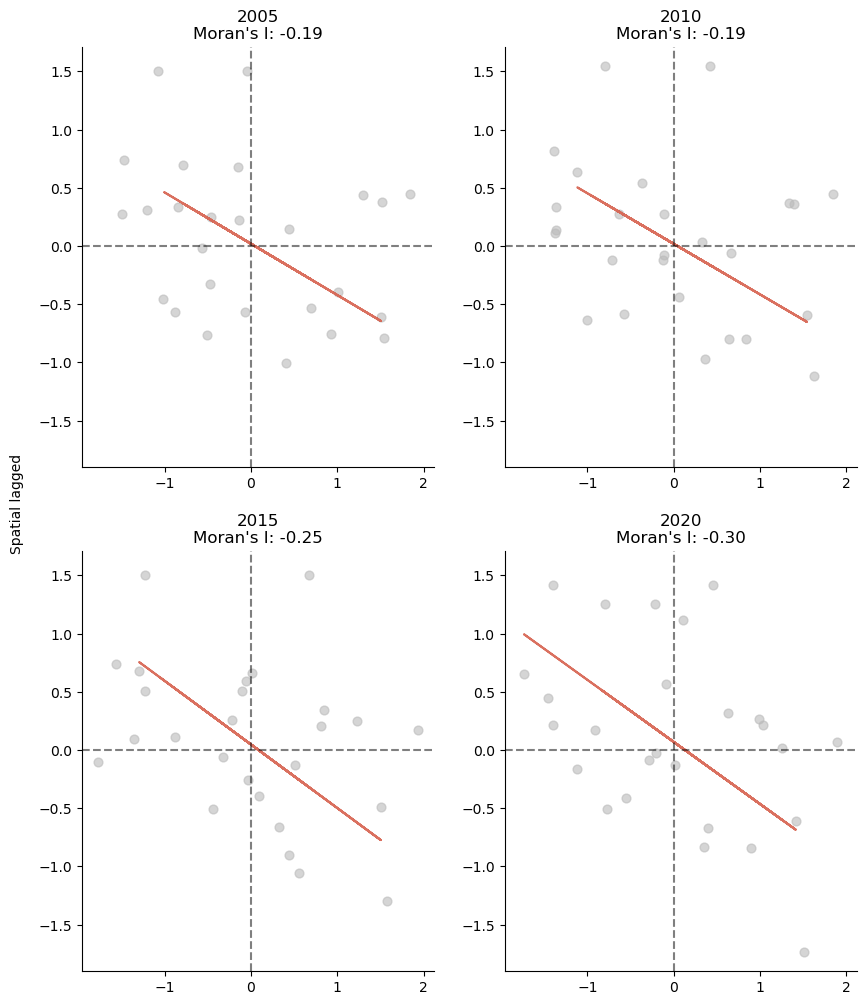

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 12))
for year, ax in zip((2005, 2010, 2015, 2020), axes.flatten()):
    moran = moran_results[year]
    moran_scatterplot(moran, p=0.05, ax=ax, aspect_equal=False)
    ax.set(
        title=f"{year}\nMoran's I: {moran.I:.2f}",
        ylabel="", xlabel="",
    )
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['left'].set_position(('axes', 0))
fig.text(0.06, 0.5, 'Spatial lagged', ha='center', va='center', rotation='vertical')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')

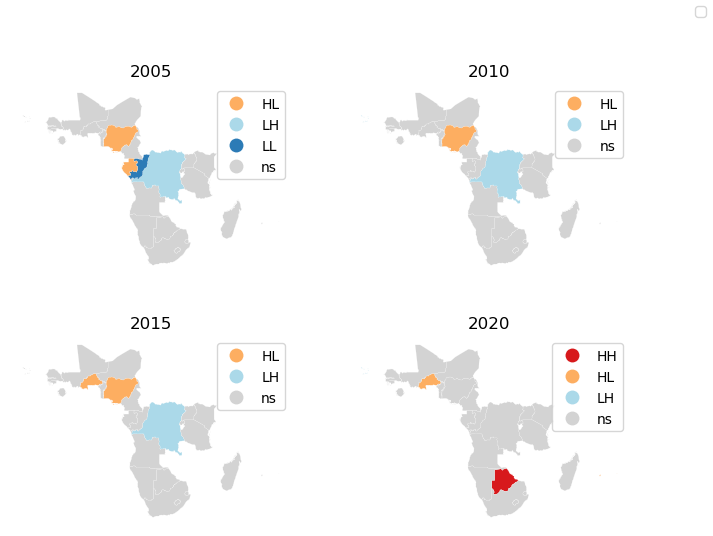

In [ ]:
from splot.esda import lisa_cluster
w = get_weights(
    "neighbor",
    ROI=df.index.get_level_values(1).unique().tolist(), 
    economic_indicator=df.groupby(level=1)["GNI per capita (constant 2015 US$)_x"].mean()
)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
for year, ax in zip((2005, 2010, 2015, 2020), axes.flatten()):
    moran_local = Moran_Local(df.loc[year, "SDI"].values, w)
    lisa_cluster(
        moran_local,
        gdf.query("GID_0 in @ROI"), ax=ax,
        p=0.1
        # legend=False,
    )
    ax.set(title=year)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)